In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Preparing Required Frameworks

In [ ]:
# install dependencies: 
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

In [ ]:
!nvidia-smi

Fri Apr  1 12:43:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import cv2
import random
from google.colab.patches import cv2_imshow
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

## Loading Data


In [ ]:
dir = '/content/gdrive/MyDrive/tooth numbering/'
df = pd.read_csv(dir + 'h_v+v4.csv')

data_number = int(len(df)/4)
data_idx = list(range(data_number))
data_list = [df.iloc[i*4]['file_name'] for i in data_idx]

# print("data_list len: "+ str(len(data_list)))
# removed_list = ['U2_OPG_101.jpg', 'U2_OPG_127.jpg', 'U2_OPG_157.jpg', 'U2_OPG_158.jpg', 'U2_OPG_16.jpg', 'U2_OPG_17.jpg', 'U2_OPG_29.jpg', 'U2_OPG_47.jpg', 'U2_OPG_70.jpg', 'U2_OPG_71.jpg'
#     , 'U2_OPG_74.jpg', 'U2_OPG_93.jpg', 'U2_OPG_94.jpg', 'cate2-00022.jpg', 'cate2-00026.jpg', 'cate2-00044.jpg', 'cate2-00119.jpg', 'cate2-00126.jpg', 'cate4-00014.jpg', 'cate4-00114.jpg'
#     , 'drsh_2020_02_100.jpeg', 'drsh_2020_02_126.jpeg', 'drsh_2020_02_402.jpeg', 'drsh_2020_02_475.jpeg', 'drsh_2020_02_491.jpeg', 'drsh_2020_02_540.jpeg', 'drsh_2020_02_602.jpeg'
#     , 'drsh_2020_02_612.jpeg', 'drsh_2020_02_8.jpeg', 'drsh_2021_04 (175).jpg']
# print("removed_list len: "+ str(len(removed_list)))


# for element in removed_list:
#     if element in data_list:
#       data_list.remove(element)
# print("final_list len: "+ str(len(data_list)))
# data_number = len(data_list)
# data_idx = list(range(data_number))

# df = df[df['file_name'].isin(data_list)]

random.shuffle(data_idx)
split_idx = int(.85*data_number)
train_idx, validation_idx = data_idx[:split_idx], data_idx[split_idx:]

df_train = pd.DataFrame([df.iloc[(i*4)+j] for i in train_idx for j in [0,1,2,3]])
df_validation = pd.DataFrame([df.iloc[(i*4)+j] for i in validation_idx for j in [0,1,2,3]])

# df_train.to_csv(dir + 'train.csv')
# df_validation.to_csv(dir + 'validation.csv')

print(data_number)
print(data_list[:5])
print(len(train_idx))
print(len(validation_idx))
print(len(df_train))
print(len(df_validation))
df_train.head(8)

data_list len: 1030
removed_list len: 30
final_list len: 1000
1000
['U2_OPG_1.jpg', 'U2_OPG_10.jpg', 'U2_OPG_100.jpg', 'U2_OPG_102.jpg', 'U2_OPG_104.jpg']
850
150
3400
600


,file_name,width,height,x_min,x_max,y_min,y_max,class_name,image_source
1476,cate4-00009.jpg,1991,1127,314,1008,233,628,1,UFBA_UESC_DENTAL_IMAGES_DEEP
1477,cate4-00009.jpg,1991,1127,999,1706,209,621,2,UFBA_UESC_DENTAL_IMAGES_DEEP
1478,cate4-00009.jpg,1991,1127,1002,1815,548,914,3,UFBA_UESC_DENTAL_IMAGES_DEEP
1479,cate4-00009.jpg,1991,1127,201,1012,554,913,4,UFBA_UESC_DENTAL_IMAGES_DEEP
2620,drsh_2020_02_398.jpeg,2657,1205,607,1342,231,658,1,Dr Shahab Clinic
2621,drsh_2020_02_398.jpeg,2657,1205,1293,1947,226,658,2,Dr Shahab Clinic
2622,drsh_2020_02_398.jpeg,2657,1205,1301,2099,531,942,3,Dr Shahab Clinic
2623,drsh_2020_02_398.jpeg,2657,1205,566,1334,542,977,4,Dr Shahab Clinic


## Creating Dataset

In [ ]:
def dataset_builder(dir, flag='None'):
  if flag=='train':
    # print('train data')
    path = os.path.join(dir, 'train.csv')
    anno = pd.read_csv(path)
    # print(anno.head())   
  elif flag=='validation':
    # print('validation data')
    path = os.path.join(dir, 'validation.csv')
    anno = pd.read_csv(path)
    # print(anno.head())
  else:
    print('other data')

  datadict = []
  ctr = 1
  for idx, row in anno.iterrows():
    if ctr == 1:
      record = {}
      record['file_name'] = os.path.join(dir, 'images', row['file_name'])
      record['image_id'] = int((idx/4) + 1)
      record['height'] = row['height']
      record['width'] = row['width']
      objs = []
      obj = {
            'bbox' : [row['x_min'], row['y_min'], row['x_max'], row['y_max']],
            'bbox_mode' : BoxMode.XYXY_ABS,
            'category_id' : row['class_name'] -1
        }
      objs.append(obj)
      # print(record)
    else:
        obj = {
            'bbox' : [row['x_min'], row['y_min'], row['x_max'], row['y_max']],
            'bbox_mode' : BoxMode.XYXY_ABS,
            'category_id' : row['class_name'] -1
        }
        objs.append(obj)
    ctr = ctr + 1
    if ctr == 5:
      record['annotations'] = objs
      datadict.append(record)
      ctr = 1

  return datadict

In [ ]:
dir = '/content/gdrive/MyDrive/tooth numbering/'
for x in ['train', 'validation']:
  DatasetCatalog.register('quadrant_' + x, lambda x=x : dataset_builder(dir, x))
  MetadataCatalog.get('quadrant_' + x).set(thing_classes=['upper_right', 'upper_left', 'lower_left', 'lower_right'])

## Visualizing some sample annotated data

/content/gdrive/MyDrive/tooth numbering/images/drsh_2021_04 (17).jpg


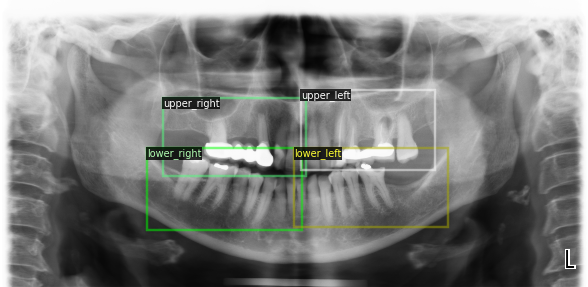

/content/gdrive/MyDrive/tooth numbering/images/drsh_2020_02_45.jpeg


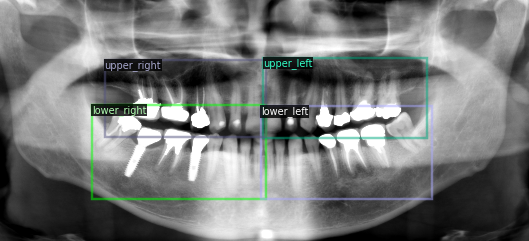

/content/gdrive/MyDrive/tooth numbering/images/cate2-00015.jpg


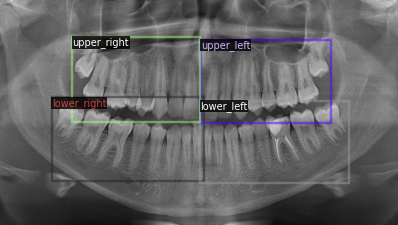

In [ ]:
quadrant_metadata = MetadataCatalog.get('quadrant_train')
train_dataset = dataset_builder(dir, 'train')
for i in random.sample(train_dataset, 3):
  print(i['file_name'])
  img = cv2.imread(i['file_name'])
  visualizer = Visualizer(img[:, :, ::-1], metadata=quadrant_metadata, scale=0.2)
  out = visualizer.draw_dataset_dict(i)
  cv2_imshow(out.get_image()[:, :, ::-1])

## Detectron2 Model Preparation

In [ ]:
class MyTrainer(DefaultTrainer):
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder is None:
        os.makedirs("dental_eval", exist_ok=True)
        output_folder = "dental_eval"
    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
cfg = get_cfg()

# cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

# cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml'))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml'))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml")

# cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/retinanet_R_50_FPN_3x.yaml'))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")

cfg.DATASETS.TRAIN = ('quadrant_train',)
cfg.DATASETS.TEST = ("quadrant_validation",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 400
cfg.SOLVER.MAX_ITER = 700
cfg.SOLVER.STEPS = (450,550,650)
cfg.SOLVER.GAMMA = 0.1
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
# cfg.MODEL.RETINANET.NUM_CLASSES = 4
cfg.TEST.EVAL_PERIOD = 200

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg)

[04/01 18:40:00 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

## Training

In [ ]:
trainer.resume_or_load(resume=False)
trainer.train()

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[04/01 18:40:05 d2.engine.train_loop]: Starting training from iteration 0
[04/01 18:41:22 d2.utils.events]:  eta: 0:44:03  iter: 19  total_loss: 3.182  loss_cls: 1.547  loss_box_reg: 0.955  loss_rpn_cls: 0.585  loss_rpn_loc: 0.103  time: 3.8941  data_time: 0.0662  lr: 0.000048  max_mem: 7728M
[04/01 18:42:43 d2.utils.events]:  eta: 0:43:29  iter: 39  total_loss: 2.183  loss_cls: 0.950  loss_box_reg: 0.954  loss_rpn_cls: 0.164  loss_rpn_loc: 0.094  time: 3.9581  data_time: 0.0317  lr: 0.000098  max_mem: 7728M
[04/01 18:44:01 d2.utils.events]:  eta: 0:42:02  iter: 59  total_loss: 1.959  loss_cls: 0.817  loss_box_reg: 0.938  loss_rpn_cls: 0.114  loss_rpn_loc: 0.086  time: 3.9492  data_time: 0.0308  lr: 0.000148  max_mem: 7728M
[04/01 18:45:20 d2.utils.events]:  eta: 0:40:43  iter: 79  total_loss: 1.779  loss_cls: 0.703  loss_box_reg: 0.938  loss_rpn_cls: 0.059  loss_rpn_loc: 0.071  time: 3.9472  data_time: 0.0279  lr: 0.000198  max_mem: 7728M
[04/01 18:46:38 d2.utils.events]:  eta: 0:39:1

##Evaluating trained model

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/output/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

In [ ]:
evaluator = COCOEvaluator("quadrant_train", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "quadrant_train")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [04/01 19:31:57 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'quadrant_train'. Trying to convert it to COCO format ...
[04/01 19:31:57 d2.data.datasets.coco]: Converting annotations of dataset 'quadrant_train' to COCO format ...)
[04/01 19:31:58 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[04/01 19:31:58 d2.data.datasets.coco]: Conversion finished, #images: 850, #annotations: 3400
[04/01 19:31:58 d2.data.datasets.coco]: Caching COCO format annotations at './output/quadrant_train_coco_format.json' ...
[04/01 19:31:59 d2.data.common]: Serializing 850 elements to byte tensors and concatenating them all ...
[04/01 19:31:59 d2.data.common]: Serialized dataset takes 0.28 MiB
[04/01 19:31:59 d2.evaluation.evaluator]: Start inference on 850 images
[04/01 19:32:06 d2.evaluation.evaluator]: Inference done 11/850. 0.5958 s / img. ETA=0:08:21
[04/01 19:32:11 d2.evaluation.evaluator]: Inference done 20/850. 0.5944 s / img. ETA=0:08:15


OrderedDict([('bbox',
              {'AP': 68.46114430690334,
               'AP-lower_left': 67.77742713359538,
               'AP-lower_right': 73.95131994031193,
               'AP-upper_left': 56.72970234508148,
               'AP-upper_right': 75.38612780862455,
               'AP50': 84.73592867567275,
               'AP75': 83.67862532291758,
               'APl': 68.46114430690334,
               'APm': nan,
               'APs': nan})])

## Visualizing some outputs

In [ ]:
def label_correction(outputs):
  height, width = outputs['instances']._image_size
  boxes = outputs['instances'].pred_boxes
  classes = outputs['instances'].pred_classes
  # print(classes)
  for i in range(len(boxes)):
    # print(boxes[i].tensor)
    if boxes[i].tensor[0,0] < width/3 and boxes[i].tensor[0,1] < height/2.5:
      # print('upper right')
      classes[i] = 0
    if boxes[i].tensor[0,0] > width/3 and boxes[i].tensor[0,1] < height/2.5:
      # print('upper left')
      classes[i] = 1
    if boxes[i].tensor[0,0] > width/3 and boxes[i].tensor[0,1] > height/2.5:
      # print('lower right')
      classes[i] = 2
    if boxes[i].tensor[0,0] < width/3 and boxes[i].tensor[0,1] > height/2.5:
      # print('lower left')
      classes[i] = 3

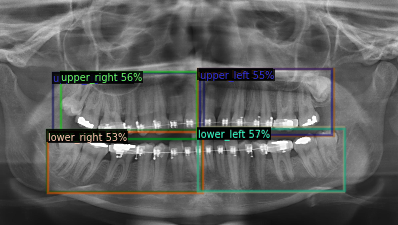

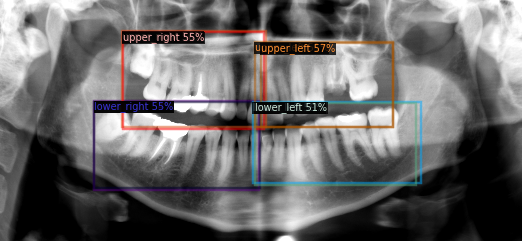

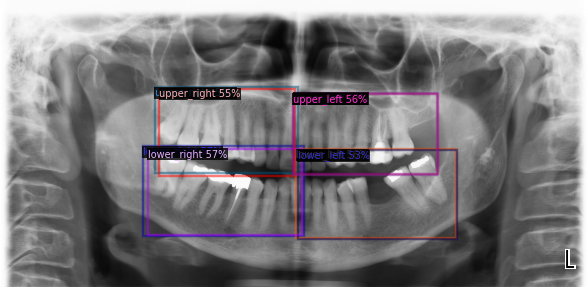

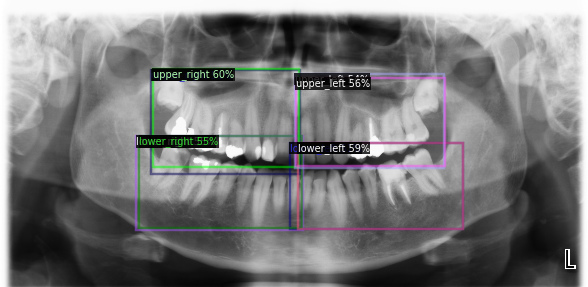

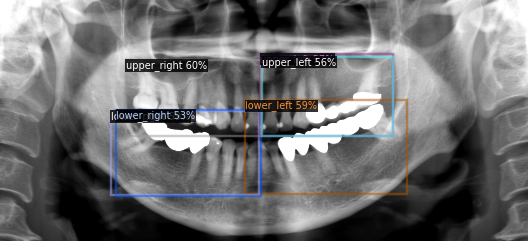

In [ ]:
dataset_dicts = dataset_builder(dir, 'validation')
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    label_correction(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=quadrant_metadata, 
                   scale=0.2, 
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])